**EL5206 Laboratorio de Inteligencia Computacional y Robótica**

**Unidad 1: Procesamiento de Imágenes**
#**Proyecto Final**


*   Eduardo Calatayud Muñoz




Se importan las librerías que vamos a usar en esta práctica y se leen las imágenes.

In [ ]:
# Se importan las librerías a usar
import cv2
#import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import math
from tqdm import tqdm
import torch # Yolo v5
from shutil import rmtree
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Colores básicos
rojo = (255,0,0)
verde = (0,255,0)
azul = (0,0,255)

In [ ]:
# Borrar y crear una carpeta nueva de Entrada
path_save="/content/drive/MyDrive/Inteligencia_Computacional/Entrada"
try:
    rmtree(path_save)
except:
     pass

if not os.path.exists(path_save):
    os.makedirs(path_save)

# Borrar y crear una carpeta nueva de Salida
path_save="/content/drive/MyDrive/Inteligencia_Computacional/Salida"
try:
    rmtree(path_save)
except:
     pass

if not os.path.exists(path_save):
    os.makedirs(path_save)

video_partido1_1 = '/content/drive/MyDrive/Inteligencia_Computacional/IMG_0066.mov'

ce = 0

# Abre el video
cap = cv2.VideoCapture(video_partido1_1)

# Obtiene la tasa de fps del video
fps = cap.get(cv2.CAP_PROP_FPS)
print("Tasa de fps del video:", fps)

# Inicializa un array para almacenar los nombres de los fotogramas
nombres_frames_entrada = []

# Bucle para leer y almacenar cada fotograma
while True:
    ret, frame = cap.read()
    if not ret:
        break

    ce+=1
    path_save = "/content/drive/MyDrive/Inteligencia_Computacional/Entrada/"
    cv2.imwrite(path_save + "frame_entrada_{:04d}.jpg".format(ce), cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Almacena los nombres de los fotograma en la lista

# Cierra el objeto de video
cap.release()

Tasa de fps del video: 30.0


In [ ]:
import os
lista_frames = os.listdir("/content/drive/MyDrive/Inteligencia_Computacional/Entrada")
lista_frames = sorted(lista_frames)
len(lista_frames)

210

## **Parte 1: Diferenciación de zonas en la cancha de fútbol**

Primero resaltamos el color rojo de la imágen ya que la línea del área es de este color. Después, se aplica el algoritmo aplicado es la Transformada de Hough Probabilístico, ampliamente utilizado para detectar líneas en una imágen. Se ajustan los parámetros de la Transformada para detectar solo la línea del área.

Después se crean dos máscaras binarias para las zonas de la izquierda (área) y de la derecha (fuera del área) de la línea, de tal forma que al hacer la operación binaria AND solo se muestre esa zona de la imágen. La operación binaria AND funciona de la siguiente manera:
- Si el píxel correspondiente en la máscara es 1, se mantendrá el valor original del píxel en la imagen.
- Si el píxel correspondiente en la máscara es 0, se establecerá el valor del píxel en la imagen resultante como 0 (negro).

In [ ]:
def resaltar_linea_de_area(imagen):
  # Se divide la imágen en sus canales y se trata para resaltar el color de la línea
  b,g,r = cv2.split(imagen)
  im_tratada = cv2.subtract(b,g)

  # Aplicar umbralización binaria
  umbral = 20
  im_tratada[im_tratada < umbral] = 0
  im_tratada[im_tratada >= umbral] = 255

  #Mostrar imágen
  cv2_imshow(im_tratada)
  return(im_tratada)

In [ ]:
def diferenciacion_de_zonas(imagen_original, imagen_tratada):

  imagen_bordes = cv2.Canny(imagen_tratada, 45, 50)

  # Aplica la Transformada de Hough Probabilística sobre la imagen binarizada
  lines = cv2.HoughLinesP(imagen_bordes, rho=1, theta=np.pi/180, threshold=20, minLineLength=50, maxLineGap=15)

  # Se definen las mascaras
  mask_area = np.zeros_like(imagen_original[:, :, 0])
  mask_fuera_area = np.zeros_like(imagen_original[:, :, 0])

  # Dibuja las líneas en la imagen original
  if lines is not None:

    line = lines[0] #Tomamos la primera línea encontrada
    x1, y1, x2, y2 = line[0]
    if (x2-x1) != 0:

      m = (y2 - y1) / (x2 - x1) # Pendiente de la recta
      b = y1 - (x1 * m) # Ordenada en el origen
      angulo = math.degrees(math.atan(m)) # Ángulo de la línea con la horizontal en radianes

      # Se calculan los puntos de intersección de la línea encontrada con la imágen con la ecuación de la recta
      h, w = imagen_original.shape[:2]
      intersection_point1 = (0, int(b))
      intersection_point2 = (w - 1, int(((w - 1 - x1) * m) + y1))
      # Se dibuja la línea que abarca toda la imágen
      imagen_con_linea = imagen_original.copy()
      imagen_con_linea = cv2.line(imagen_con_linea, intersection_point1, intersection_point2, (255, 0, 0), 2)

      #Mostrar imágen
      cv2_imshow(cv2.cvtColor(imagen_con_linea, cv2.COLOR_BGR2RGB))


      # División de la imágen por la línea
      # Crea una máscara utilizando la ecuación de la línea
      # Si el ángulo es mayor que 90 grados el área está a la derecha de la línea, si no a la izquierda.
      if -angulo<90: # Se pone el ángulo negativo por los ejes que asigna opencv a la imagen
        for x in range(w):
          y = int(m * x + b)
          if y<0: break
          else:
            mask_area[:y, x] = 255
      else:
        for x in range(w):
          y = int(m * x + b)
          if y<0: break
          else:
            mask_area[y:, x] = 255

    # Crea una máscara para la región a la derecha
    mask_fuera_area = 255 - mask_area

    # Aplica las máscaras a la imagen original
    area = cv2.bitwise_and(imagen_original, imagen_original, mask=mask_area)
    fuera_area = cv2.bitwise_and(imagen_original, imagen_original, mask=mask_fuera_area)

  return mask_area
  #return area, fuera_area

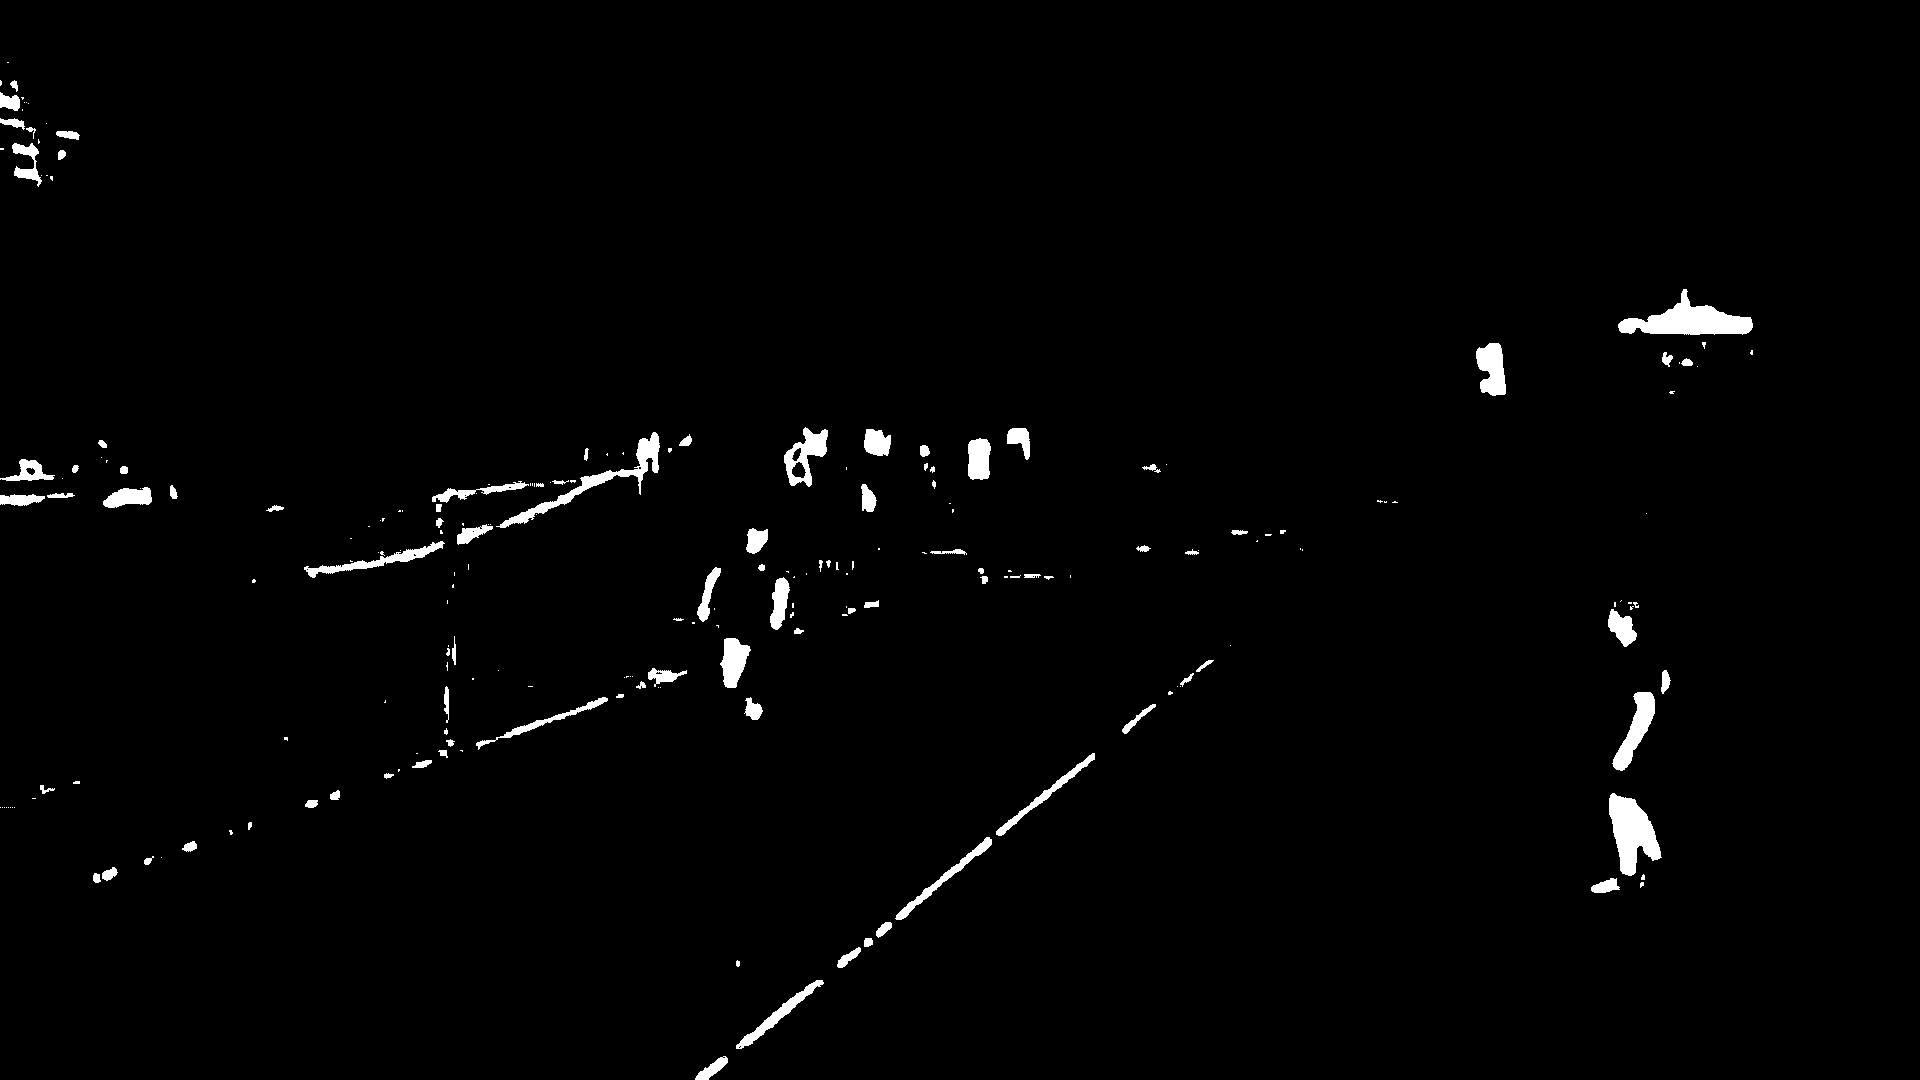

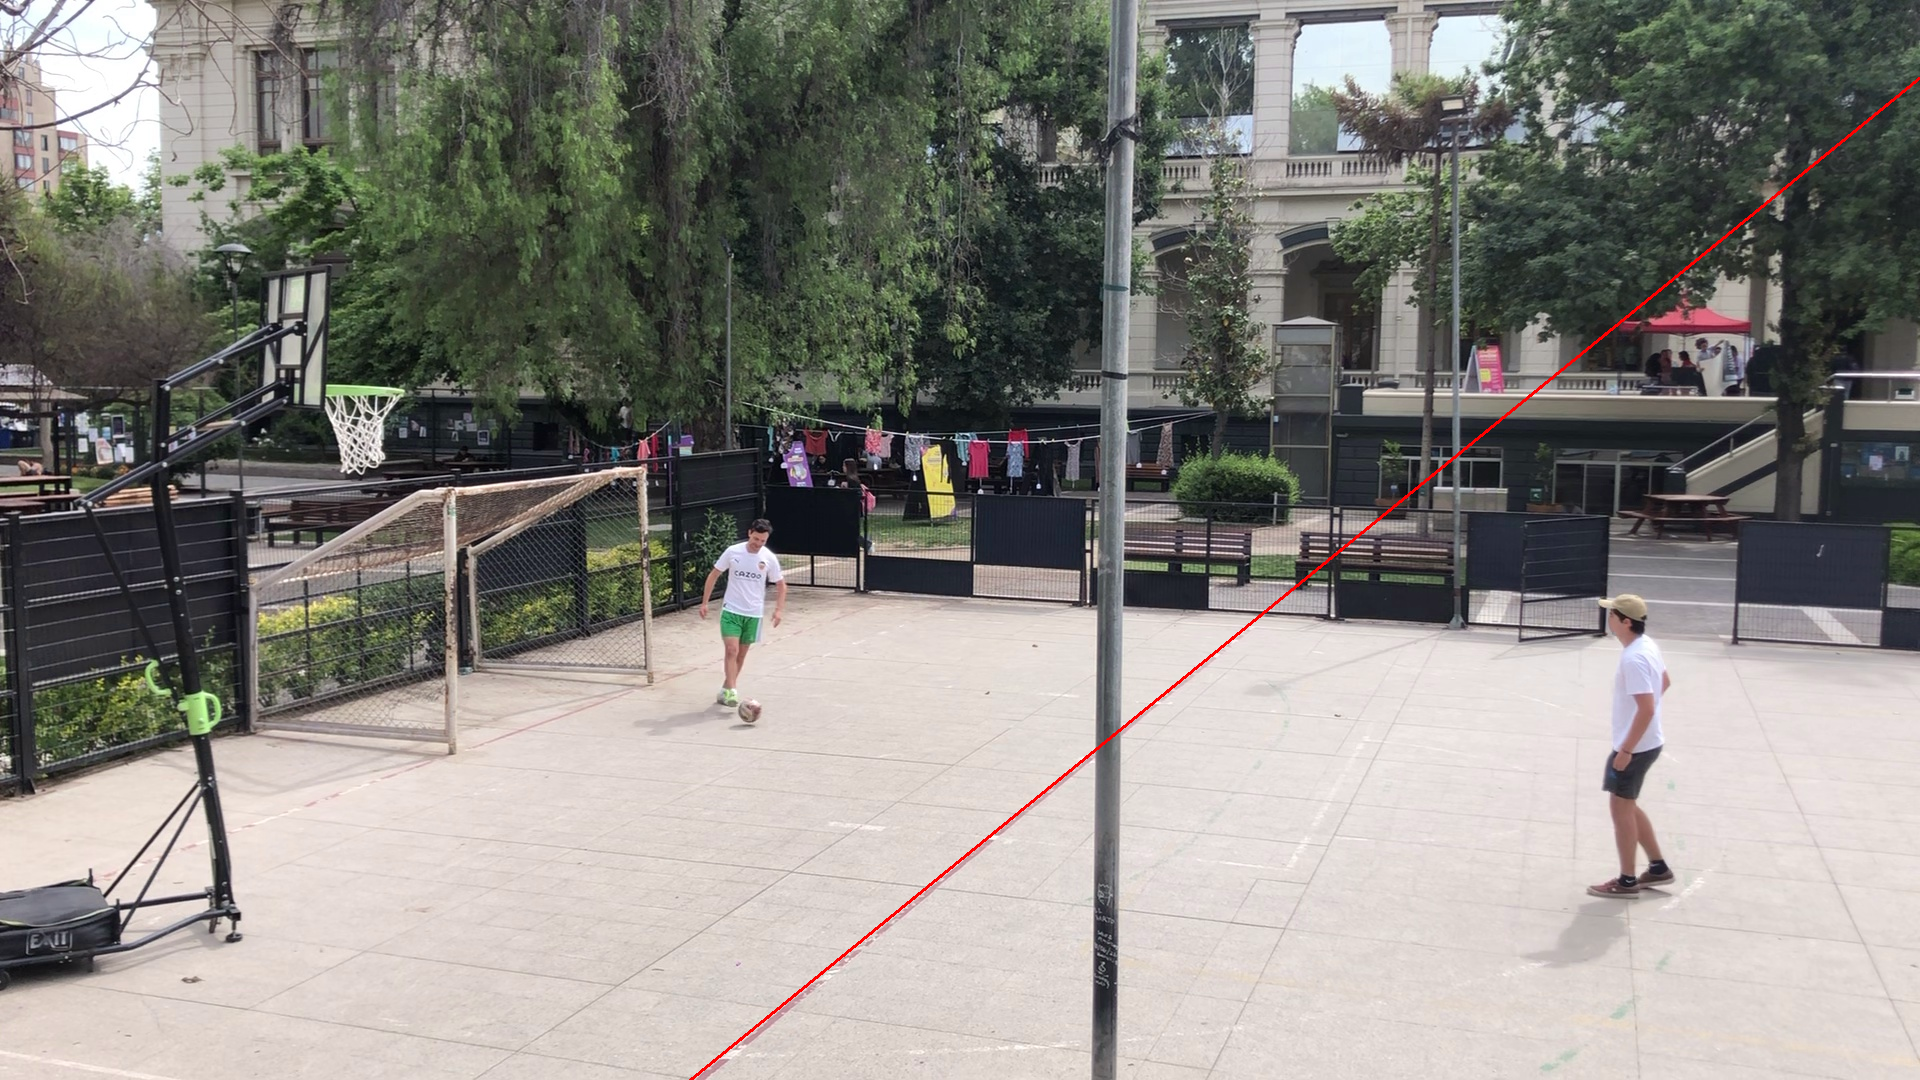

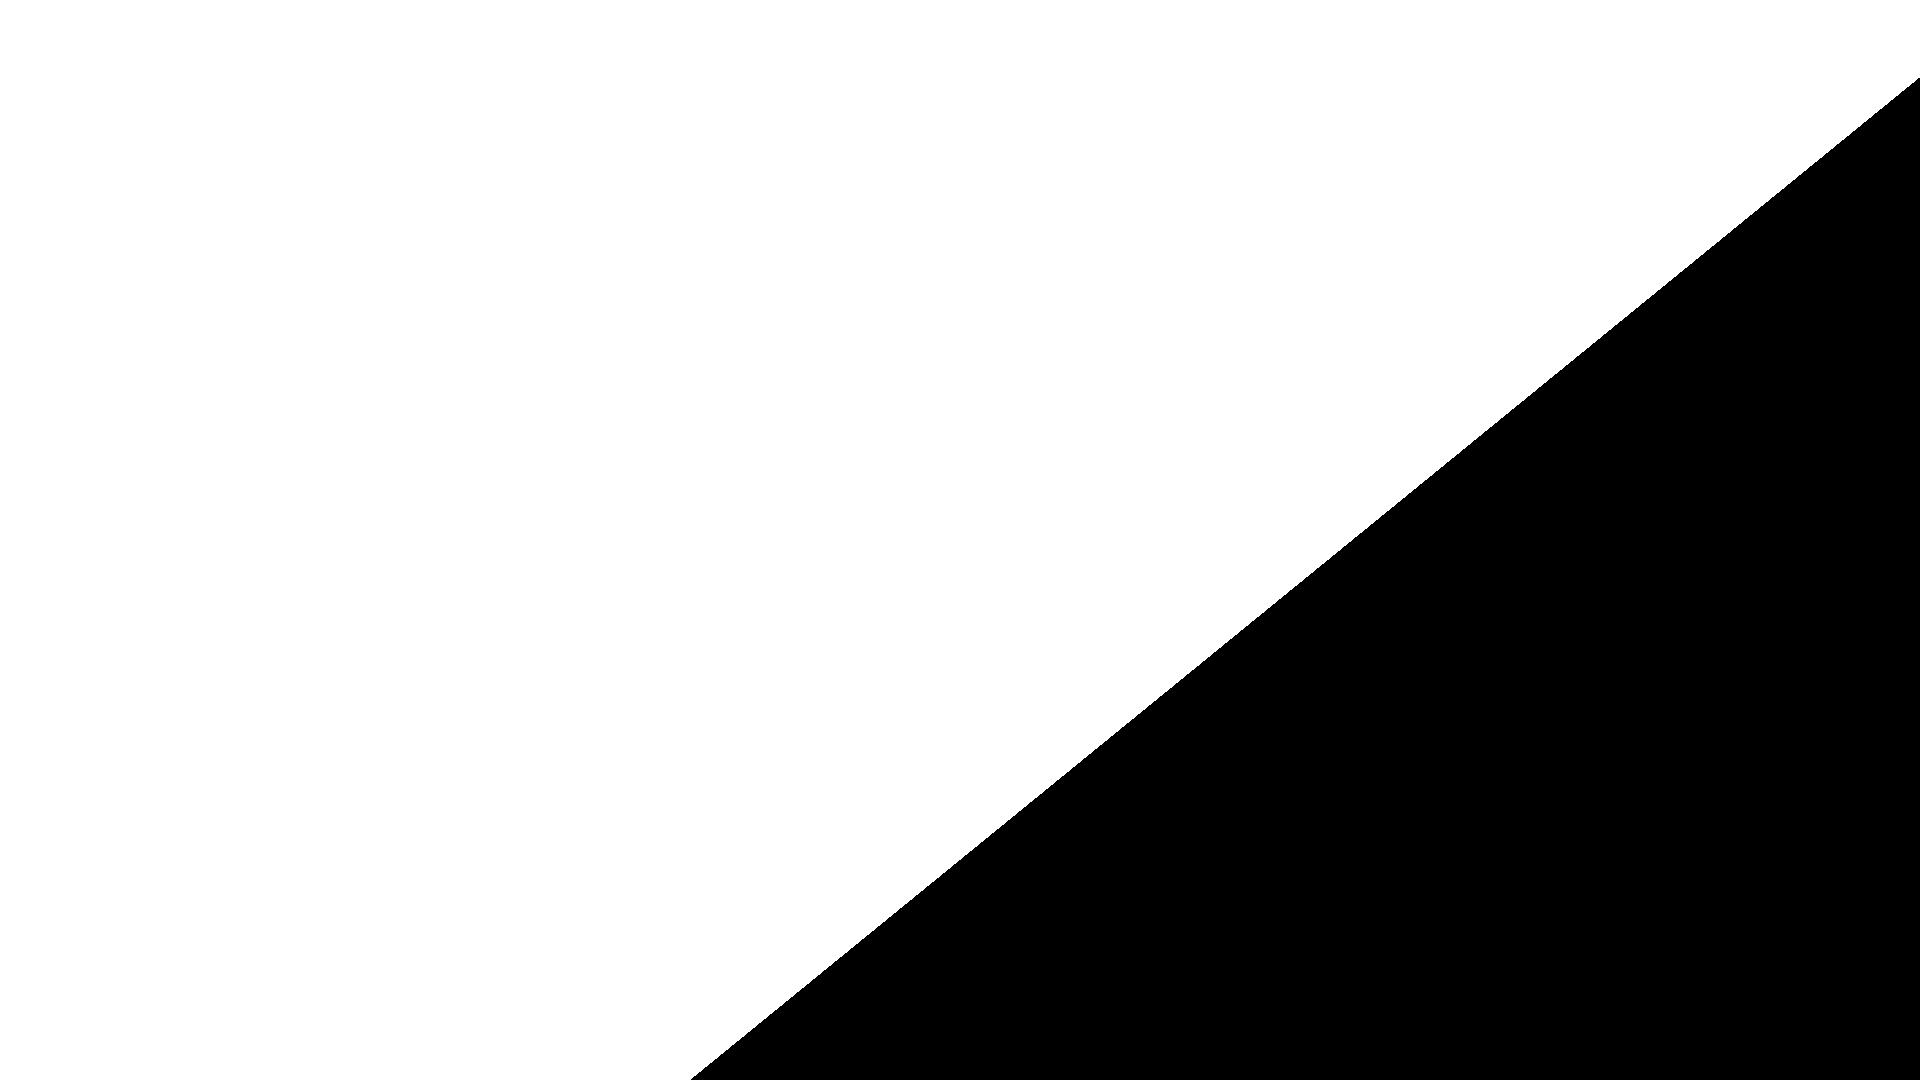

In [ ]:
fondo_cancha = cv2.imread("/content/drive/MyDrive/Inteligencia_Computacional/Entrada/" + str(lista_frames[0]))
im_tratada = resaltar_linea_de_area(fondo_cancha)
area = diferenciacion_de_zonas(fondo_cancha, im_tratada)
# Muestra la imagen resultante
cv2_imshow(area)

cv2.destroyAllWindows()

## **Parte 2: Detección del balón**

Se utiliza yolo v5 para la detección del balón en el frame. Después se dibuja un rectángulo con las dimensiones de la bola.

In [ ]:
# Se carga el modelo de detección de formas Yolo v5
modelo = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-12-3 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 


In [ ]:
def deteccion_de_balon(modelo, imagen_original, color):
  results = modelo(imagen_original)
  P = results.pandas().xyxy[0]
  #print(P[P["class"]==32])

  # Crea una máscara
  mask_balon = np.zeros_like(imagen_original[:, :, 0])

  # Se recorren todos los objetos detectados y solo actuamos sobre los sports ball con una confianza mínima
  for i in P.index:
    if P["class"][i] == 32 and P["confidence"][i]>=0.25:
      x_min = int(P["xmin"][i])
      x_max = int(P["xmax"][i])
      y_min = int(P["ymin"][i])
      y_max = int(P["ymax"][i])

      imagen_con_rectangulo = imagen_original.copy()
      cv2.rectangle(imagen_con_rectangulo, (x_min, y_min), (x_max, y_max), color, 2)


      # Se pasan a 1 los pixeles del balón
      mask_balon[y_min:y_max, x_min:x_max] = 255
      # Aplica las máscaras a la imagen original
      balon = cv2.bitwise_and(imagen_original, imagen_original, mask=mask_balon)

      return imagen_con_rectangulo, mask_balon

  return imagen_original, mask_balon

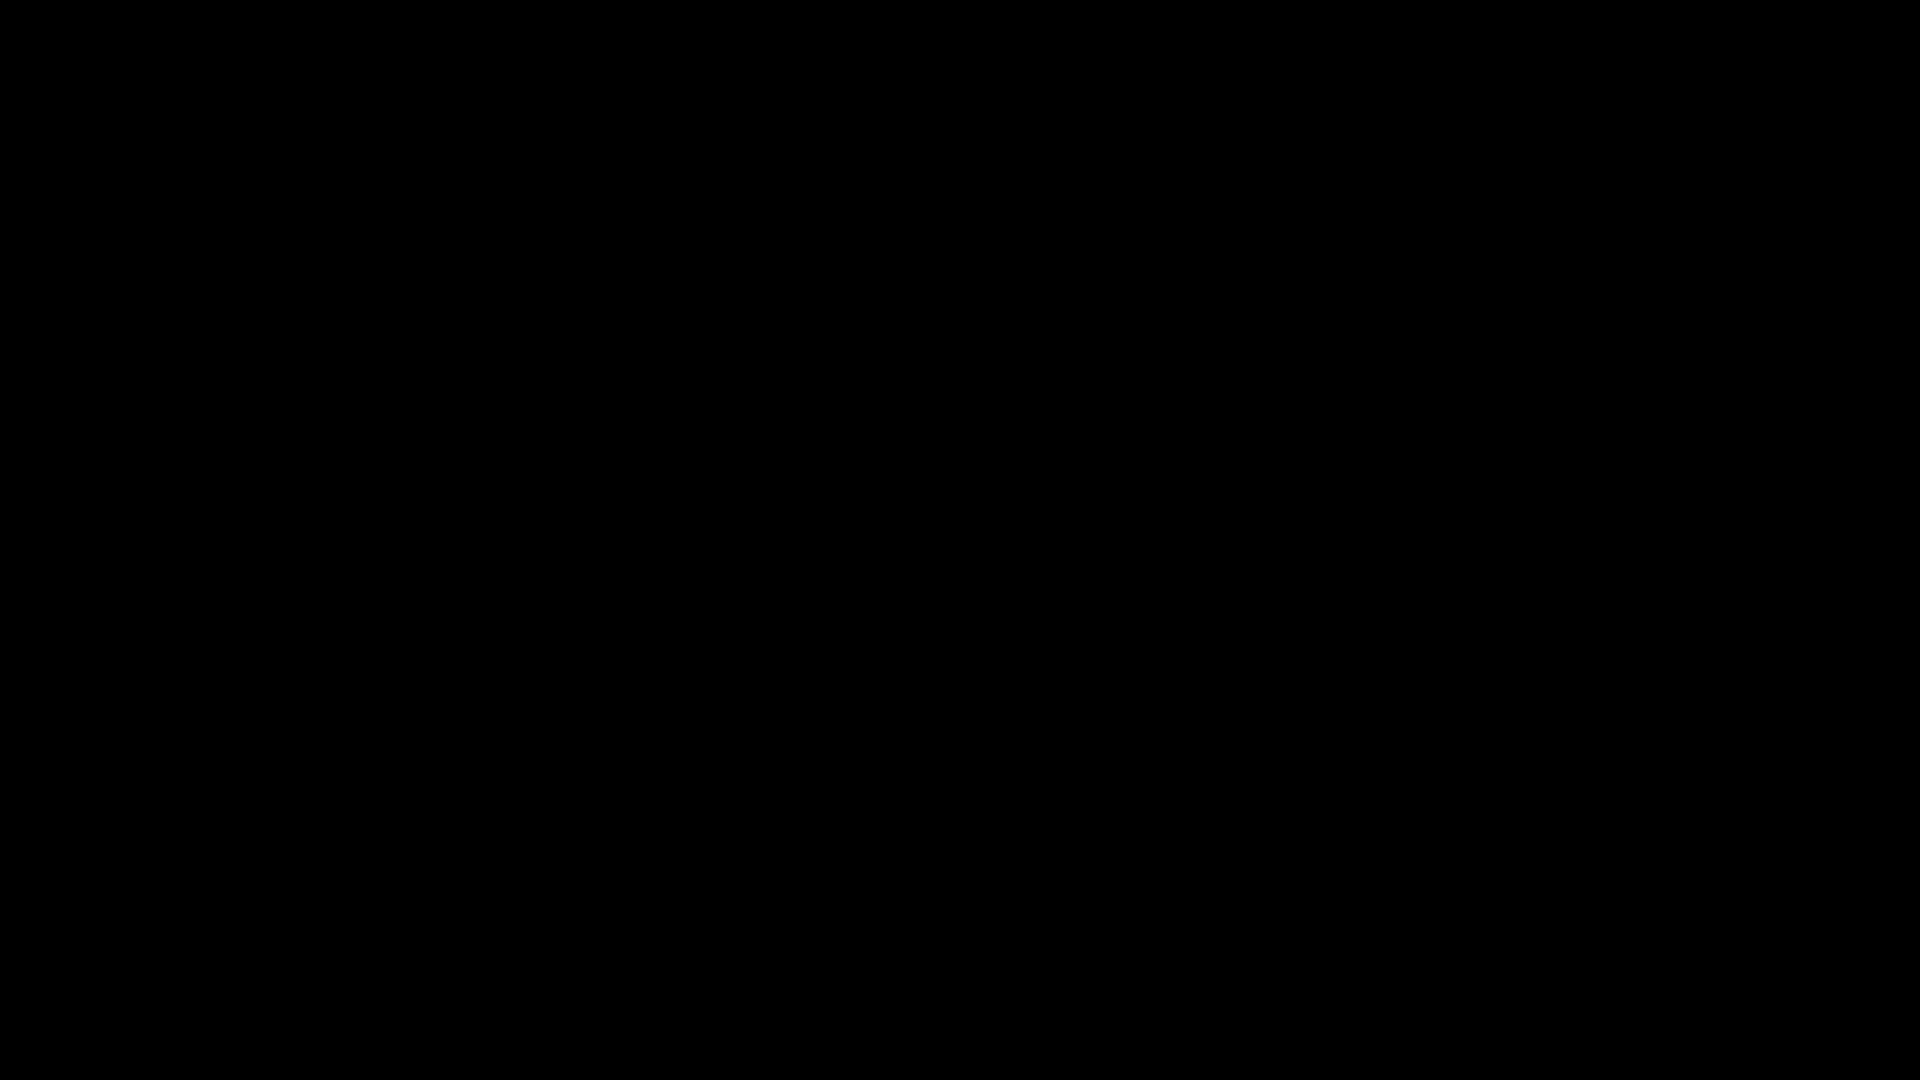

In [ ]:
im_partido = cv2.imread("/content/drive/MyDrive/Inteligencia_Computacional/Entrada/" + str(lista_frames[88]))
im_con_balon, balon = deteccion_de_balon(modelo, im_partido, azul)
im_con_balon = cv2.cvtColor(im_con_balon, cv2.COLOR_BGR2RGB)
cv2_imshow(balon)

## **Parte 3: Detección de intersecciones entre el balón y las áreas**

In [ ]:
def balon_dentro_area(mask_area, mask_balon):

  intersection = cv2.bitwise_and(mask_area, mask_balon//255)

  # Si la intersección tiene al menos un bit a 1, hay intersección
  if np.any(intersection > 0):
      return True
  else:
      return False

In [ ]:
print(len(area))
print(len(area[0]))

print(len(balon))
print(len(balon[0]))

1080
1920
1080
1920


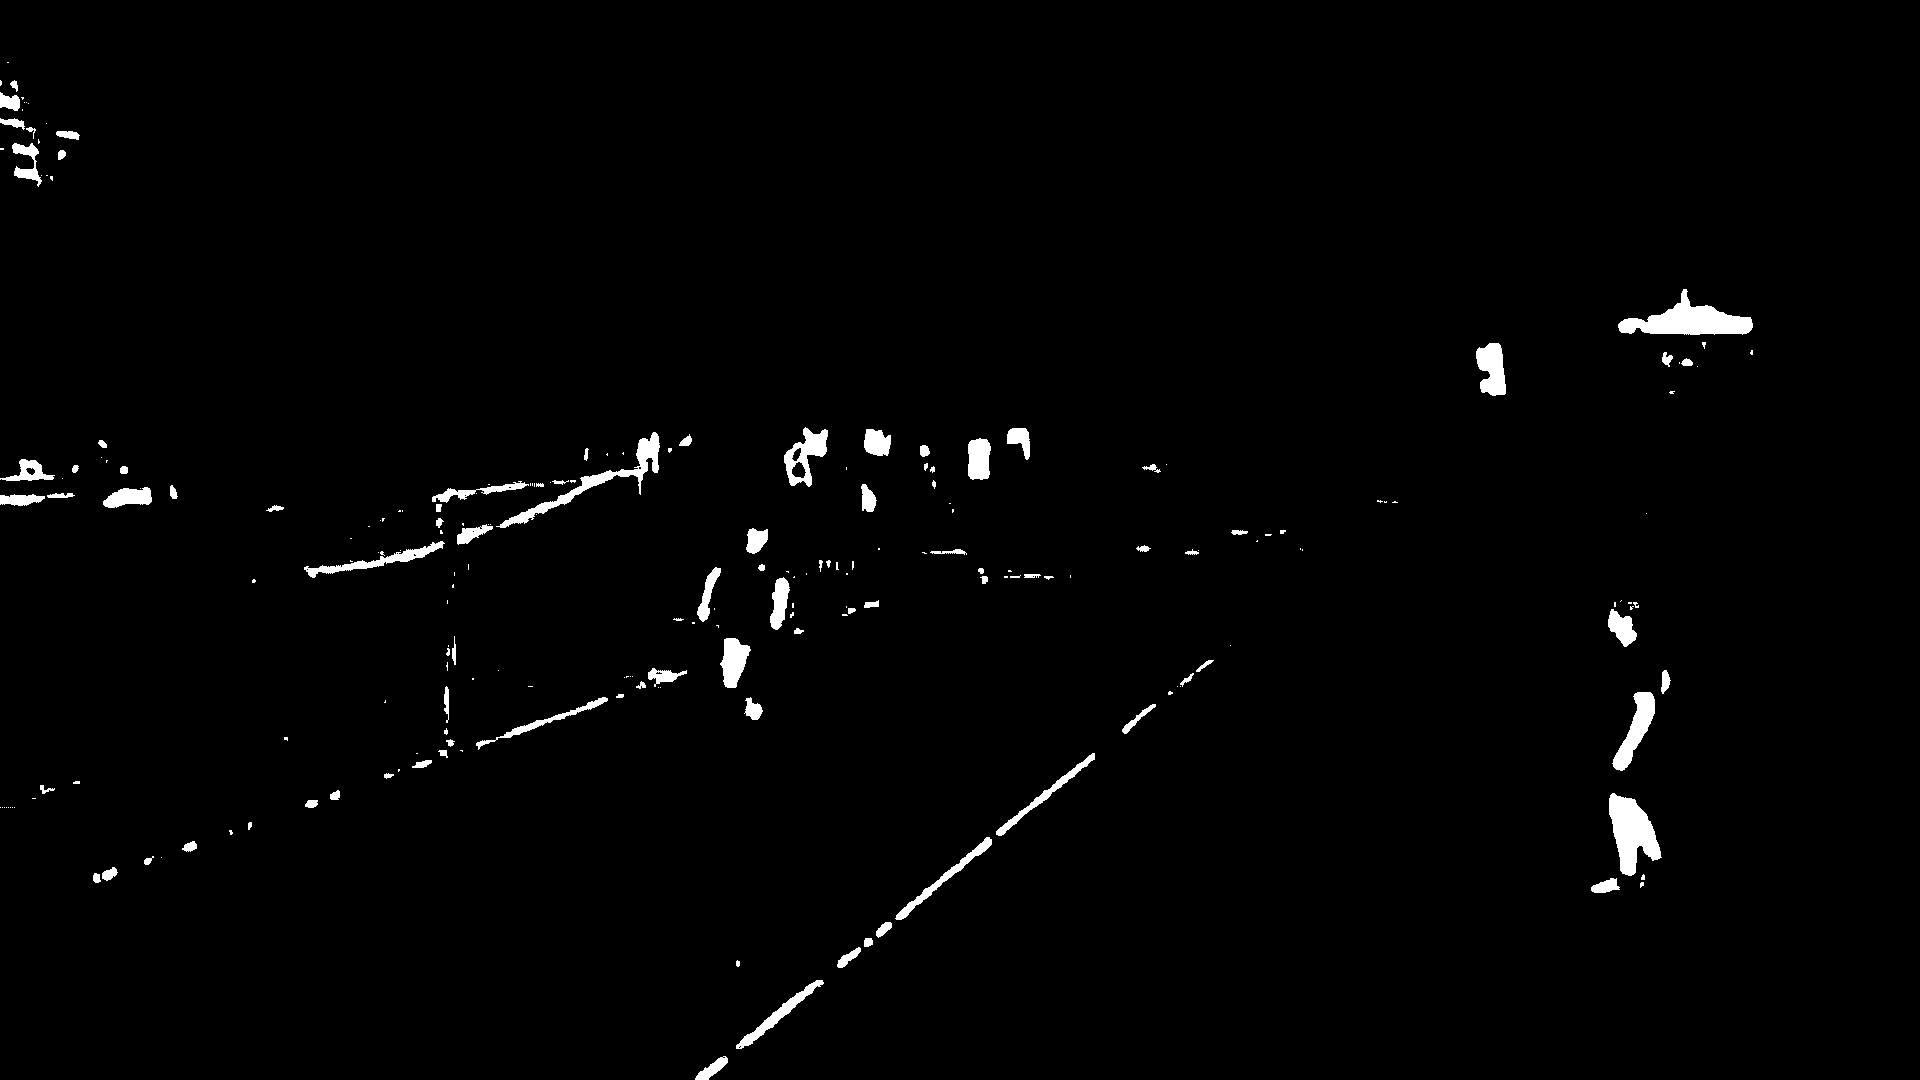

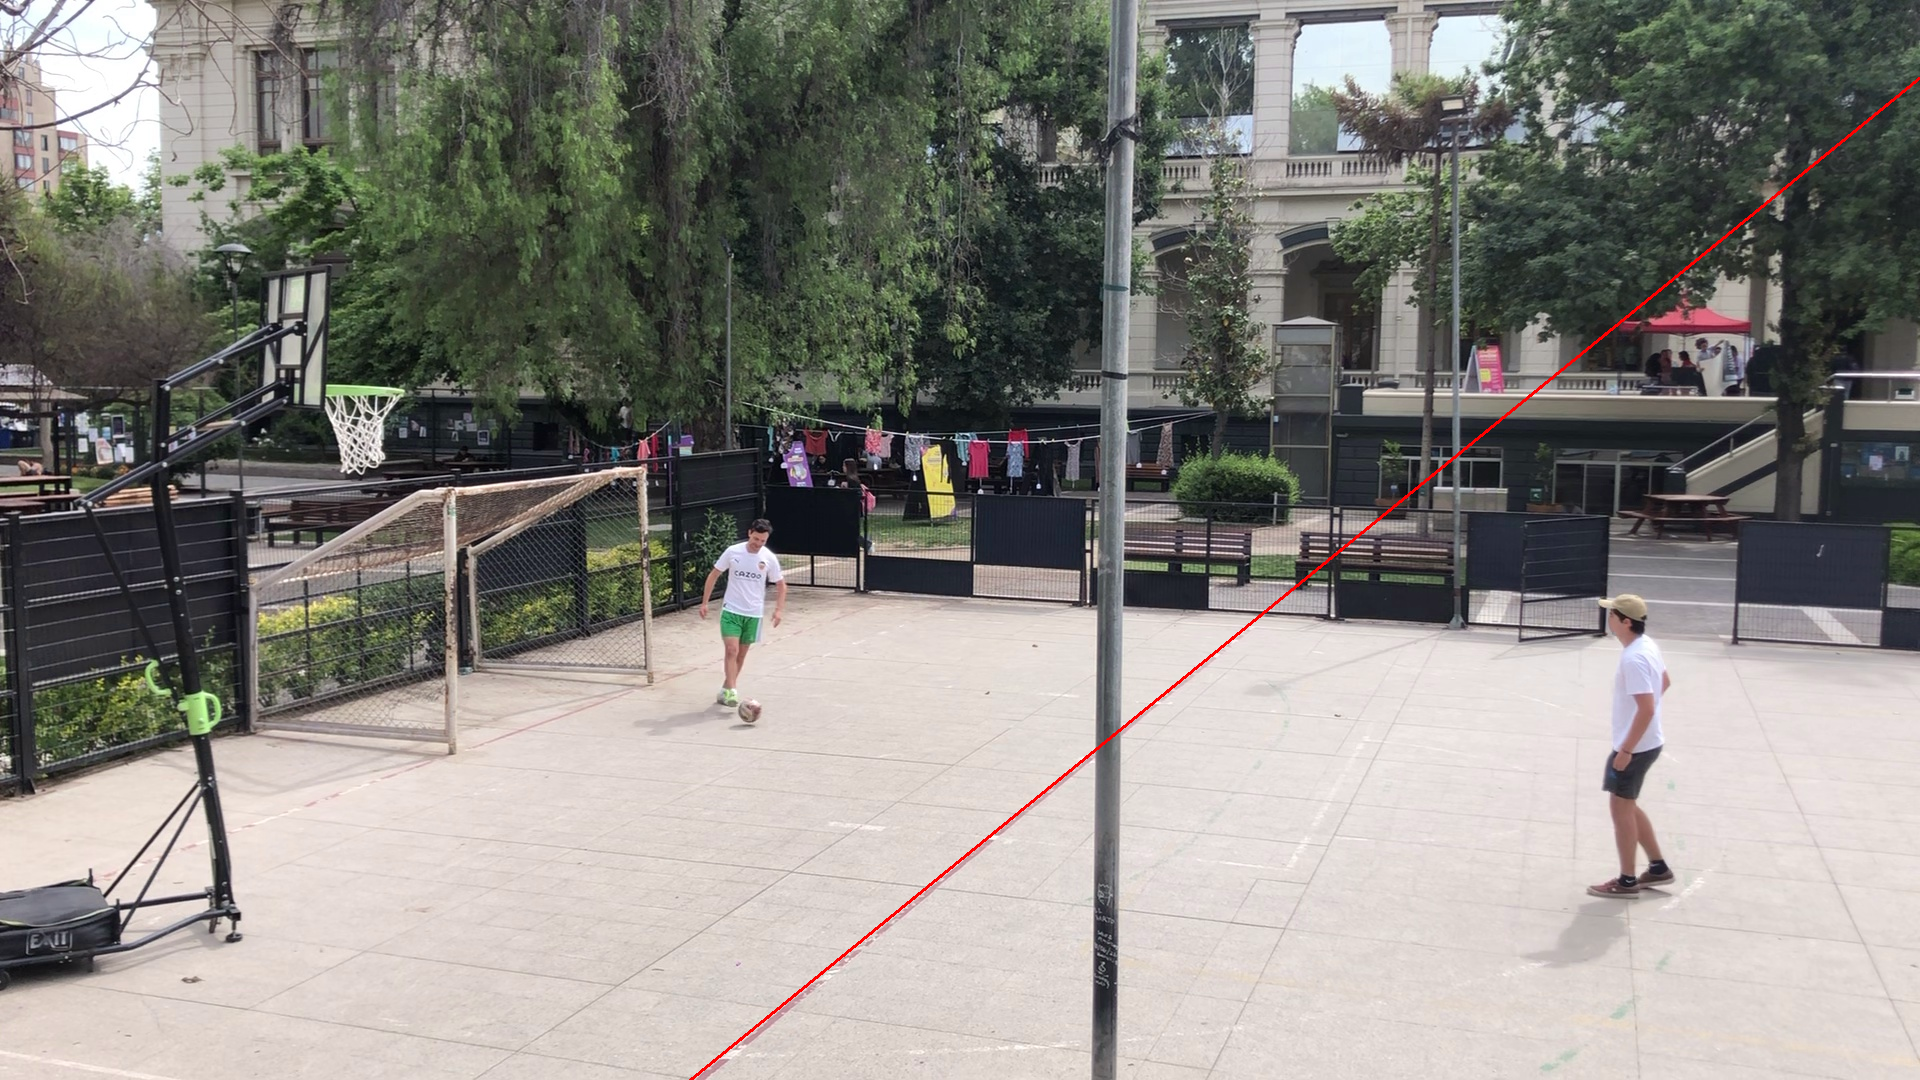

calculando: 100%|██████████| 210/210 [00:51<00:00,  4.08it/s]


In [ ]:
# Se obtienen las diferentes zonas de la cancha
fondo_cancha = cv2.imread("/content/drive/MyDrive/Inteligencia_Computacional/Entrada/" + str(lista_frames[0]))
im_binaria = resaltar_linea_de_area(fondo_cancha)
area = diferenciacion_de_zonas(fondo_cancha, im_binaria)

# Se obtiene la posición del balón
cc = 0
for im in tqdm(lista_frames, desc = "calculando"):
  im_partido = cv2.imread("/content/drive/MyDrive/Inteligencia_Computacional/Entrada/" + im)
  try:
    im_con_balon, balon = deteccion_de_balon(modelo, im_partido, azul)

    # Se comprueba si el balón se encuentra dentro del area
    balon_en_area = balon_dentro_area(area, balon)

    if balon_en_area == True:
      #print("Dentro. Las máscaras intersectan en al menos una región.")
      im_con_balon, balon = deteccion_de_balon(modelo, im_partido, verde)
      im_con_balon = cv2.cvtColor(im_con_balon, cv2.COLOR_BGR2RGB)


    else:
      #print("Fuera. Las máscaras no tienen intersección.")
      im_con_balon, balon = deteccion_de_balon(modelo, im_partido, rojo)
      im_con_balon = cv2.cvtColor(im_con_balon, cv2.COLOR_BGR2RGB)

    cc+=1
    path_save = "/content/drive/MyDrive/Inteligencia_Computacional/Salida/"
    cv2.imwrite(path_save + "frame_{:04d}.jpg".format(cc), im_con_balon)

  except:
      pass




Se crea un video a partir de los frames con el valón detectado.

In [ ]:
# Ruta de la carpeta que contiene las imágenes PNG
folder_path = "/content/drive/MyDrive/Inteligencia_Computacional/Salida"

# Obtener la lista de nombres de archivos en la carpeta
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Ordenar los nombres de archivos alfabéticamente (asegurándonos de que están en orden)
image_files.sort()

# Leer la primera imagen para obtener las dimensiones del video
first_image = cv2.imread(os.path.join(folder_path, image_files[0]))
height, width, layers = first_image.shape

# Especificar el formato del video y la frecuencia de cuadros (FPS)
video_format = cv2.VideoWriter_fourcc(*'XVID')
fps = 30  # Puedes ajustar esto según sea necesario

# Crear el objeto VideoWriter
video_path = "/content/drive/MyDrive/Inteligencia_Computacional/Salida/tracking_01.avi"
video = cv2.VideoWriter(video_path, video_format, fps, (width, height))

# Leer las imágenes y agregarlas al video
for image_file in tqdm(image_files, desc = "calculando"):
    image_path = os.path.join(folder_path, image_file)
    img = cv2.imread(image_path)
    video.write(img)

# Liberar el objeto VideoWriter
video.release()

print(f"Video creado en: {video_path}")


calculando: 100%|██████████| 210/210 [00:13<00:00, 15.03it/s]

Video creado en: /content/drive/MyDrive/Inteligencia_Computacional/Salida/tracking_01.avi
